## POINT SPREAD FUNCTION ANALYSIS

In [315]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j0,j1

Parameters

In [316]:
dx = dy = 0.005 # micro meter
Nx = Ny = 301
spanX = dx*Nx
spanY = dy*Ny

x = torch.linspace(-spanX/2, spanX/2, Nx)
y = torch.linspace(-spanY/2, spanY/2, Ny)
yy, xx = torch.meshgrid(x, y)
rr = torch.sqrt(xx**2 + yy**2)

lambda_ = 532/1000       # wave length
k = 2*torch.pi/lambda_   # wave number
a = spanX/2              # aperture radius
f = a / 0.8              # focal length

In [317]:
def plot_complex_tensor(tensor, common_title=''):
    magnitude = torch.abs(tensor)
    normalized_magnitude = (magnitude - magnitude.min()) / (magnitude.max() - magnitude.min() + 1e-10)
    phase = torch.angle(tensor)

    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(magnitude, cmap='grey')
    plt.colorbar()
    plt.title('Magnitude')

    # plt.subplot(1, 2, 1)
    # plt.imshow(normalized_magnitude, cmap='grey')
    # plt.colorbar()
    # plt.title('Normalized Magnitude')

    plt.subplot(1, 2, 2)
    plt.imshow(phase, cmap='hsv')
    plt.colorbar()
    plt.title('Phase (radians)')

    plt.suptitle(common_title)
    plt.show()

### 3.1 Transmittance of a Single Lens, 3.2 Diffraction by a Lens

In [318]:
# pupil function of a cicular lense
# eq 3.2.6
def pupil_func():
    radius_squared = rr**2
    mask = radius_squared <= a**2
    return mask.type(torch.float32)

# transmittance of thin lens: get the field after lens
# eq 3.2.1
def transmittance(U1):
    P = pupil_func()

    magnitude = torch.ones_like(rr)
    phase = (k/(2*f)) * (rr**2)
    real_part = magnitude * torch.cos(phase)
    imaginary_part = magnitude * torch.sin(phase)

    t =  P * torch.complex(real_part, imaginary_part)
    return U1*t

# field propogation to f after the lens (focal plane)
# eq 3.2.7
def propogate_to_f():
    # !!! here U0 is assumed to be 1
    K1 = torch.complex( torch.tensor(0.0), torch.tensor((torch.pi*(a**2)) / (lambda_*f)) )

    p2 = torch.tensor(-k*f)
    K2 = torch.complex(torch.cos(p2), torch.sin(p2))

    r_squared = rr**2
    p3 = -1 * (torch.pi/(lambda_*f)) * r_squared 
    K3 = torch.complex(torch.cos(p3), torch.sin(p3))

    in_bessel = (2*torch.pi*a*rr) / (lambda_*f)
    J1 = j1(in_bessel.numpy())
    J1 = torch.from_numpy(J1)
    K4 = (2*J1) / (in_bessel)
    K4[rr.shape[0]//2, rr.shape[0]//2] = 1

    U3 = K1 * K2 * K3 * K4
    return U3


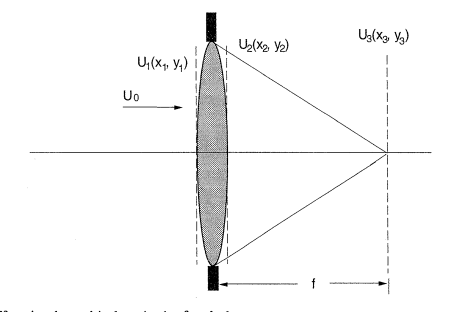

Input uniform field - U1

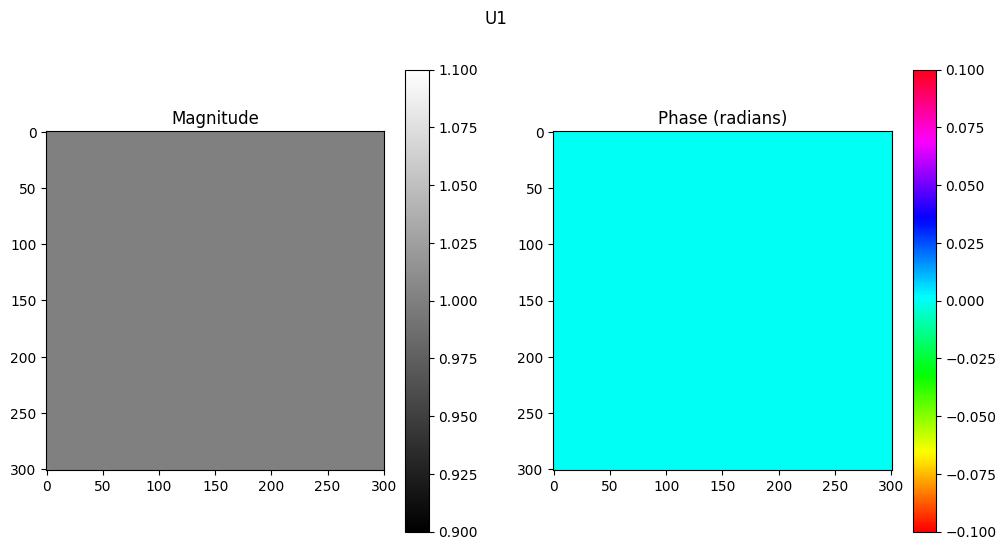

In [319]:
# Create a complex field with magnitude 1 and phase 0
U0 = 1
magnitude = U0*torch.ones_like(xx)
phase = torch.zeros_like(xx)
real_part = magnitude * torch.cos(phase)
imaginary_part = magnitude * torch.sin(phase)
U1 = torch.complex(real_part, imaginary_part)

plot_complex_tensor(U1, 'U1')

Field after circular lens - U2

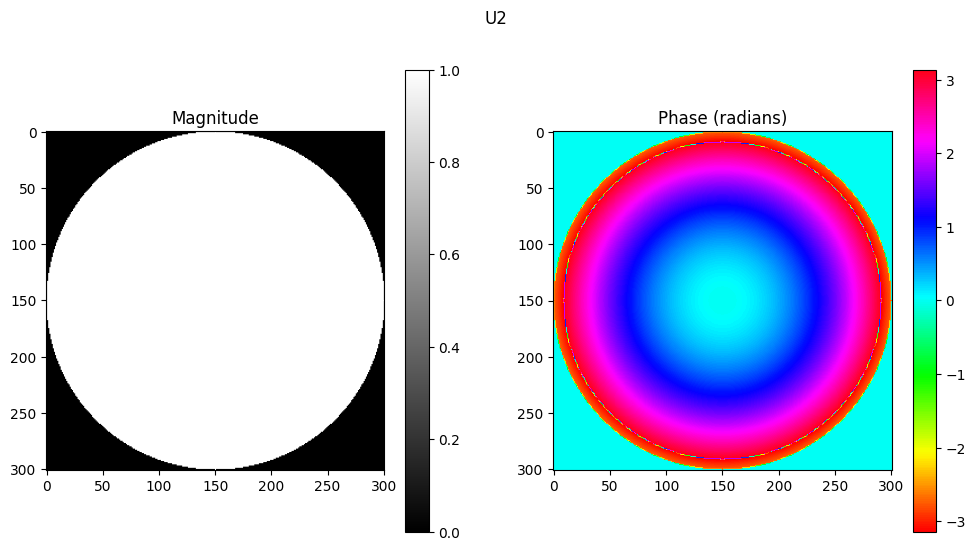

In [320]:
U2 = transmittance(U1)
plot_complex_tensor(U2, "U2")

Field at focal plane - U3

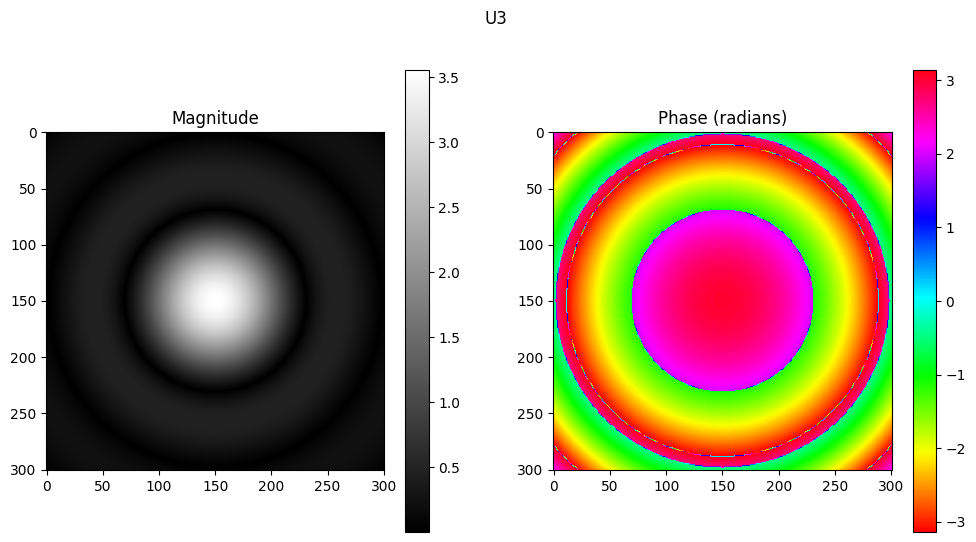

In [321]:
U3_f = propogate_to_f()
plot_complex_tensor(U3_f, "U3")

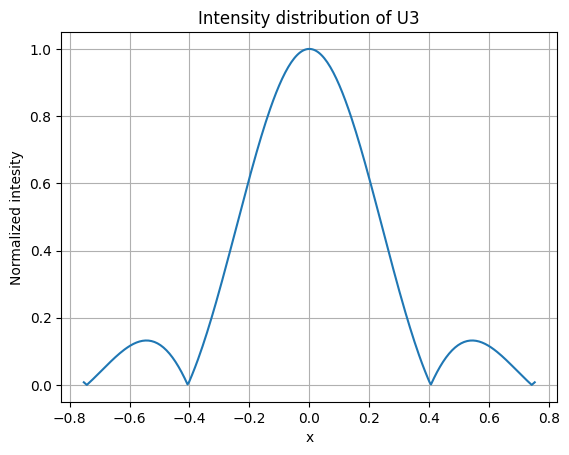

In [322]:
I = torch.abs(U3_f[Nx//2])
I = (I - I.min()) / (I.max() - I.min() + 1e-10)

plt.plot(xx[0].numpy(), I.numpy())
plt.title('Intensity distribution of U3')
plt.xlabel('x')
plt.ylabel('Normalized intesity')
plt.grid(True)
plt.show()

#### Diffraction by a thin lens in a defocus plane

In [323]:
# defocused pupil function of a cicular lense
# eq 3.2.16
def defocused_pupil_func(z):
    K1 = pupil_func()
    
    r_squared = rr**2
    p2 = (k*r_squared/2) * (1/f - 1/z)
    K2 = torch.complex(torch.cos(p2), torch.sin(p2))

    return K1 * K2

# field propogation to z = f + dz after the lens
# eq 3.2.17
def propogate_to_z(z):
    # !!! here U0 is assumed to be 1
    K1 = torch.complex( torch.tensor(0.0), torch.tensor( 1 / (lambda_*z)) )

    p2 = torch.tensor(-k*z)
    K2 = torch.complex(torch.cos(p2), torch.sin(p2))

    r_squared = rr**2
    p3 = -1 * (torch.pi/(lambda_*z)) * r_squared 
    K3 = torch.complex(torch.cos(p3), torch.sin(p3))

    # K4 = torch.complex( torch.zeros_like(rr), torch.zeros_like(rr) )
    # Nx = rr.shape[0]
    # dr2 = dx
    # r2 = rr[Nx//2, Nx//2:]
    # steps = len(r2)
    # defocused_P = defocused_pupil_func(z)[Nx//2, Nx//2:]
    # for i in range(steps):
    #     r2_i = r2[i]
    #     in_bessel = (2*torch.pi*r2_i*rr) / (lambda_*z)
    #     J0 = j0(in_bessel.numpy())
    #     J0 = torch.from_numpy(J0)
    #     K4 = K4 + defocused_P[i] * J0 * 2*torch.pi*r2_i * dr2

    Nx = rr.shape[0]
    dr2 = dx

    r2 = rr[Nx//2, Nx//2:]
    steps = len(r2)
    r2 = r2[:, None, None]
    
    defocused_P = defocused_pupil_func(z)[Nx//2, Nx//2:]
    defocused_P = defocused_P[:, None, None]

    rr_stacked = torch.stack([rr] * steps, dim=0)
    in_bessel = (2*torch.pi*r2*rr_stacked) / (lambda_*f)
    J0 = j0(in_bessel.numpy())
    J0 = torch.from_numpy(J0)

    K4 = defocused_P * J0 * 2*torch.pi*r2 * dr2
    K4 = torch.sum(K4, dim=0)

    U3 = K1 * K2 * K3 * K4
    return U3

In [324]:
torch.allclose(torch.abs(pupil_func()), torch.abs(defocused_pupil_func(f)))

True

In [325]:
torch.allclose(torch.abs(defocused_pupil_func(f-dx*10)), torch.abs(defocused_pupil_func(f+dx*10)))

True

In [326]:
U3_f_abs_1 = torch.abs(U3_f)
U3_f_normalized_1 = (U3_f_abs_1 - U3_f_abs_1.min()) / (U3_f_abs_1.max() -U3_f_abs_1.min() + 1e-10) 

U3_f_abs_2 = torch.abs(propogate_to_z(f))
U3_f_normalized_2 = (U3_f_abs_2 - U3_f_abs_2.min()) / (U3_f_abs_2.max() -U3_f_abs_2.min() + 1e-10) 

torch.allclose(U3_f_normalized_1, U3_f_normalized_2, rtol=1e-5, atol=1e-2)

True

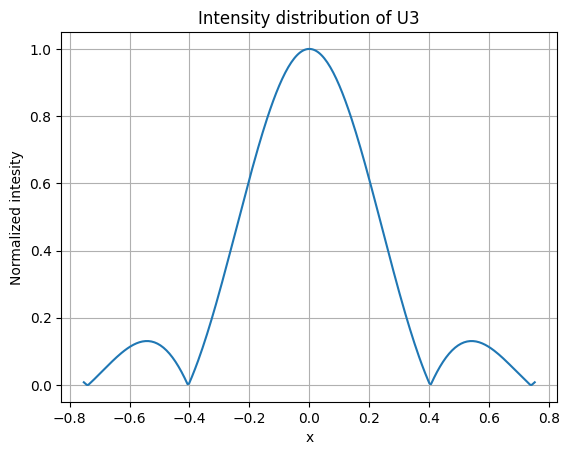

In [327]:
I = U3_f_abs_2[Nx//2]
I = (I - I.min()) / (I.max() - I.min() + 1e-10)

plt.plot(xx[0].numpy(), I.numpy())
plt.title('Intensity distribution of U3')
plt.xlabel('x')
plt.ylabel('Normalized intesity')
plt.grid(True)
plt.show()

In [328]:
dz = f/2
U_f_plus_dz = torch.abs(propogate_to_z(f+dz))
U_f_minus_dz = torch.abs(propogate_to_z(f-dz))
torch.allclose(U_f_plus_dz,  U_f_minus_dz)

False

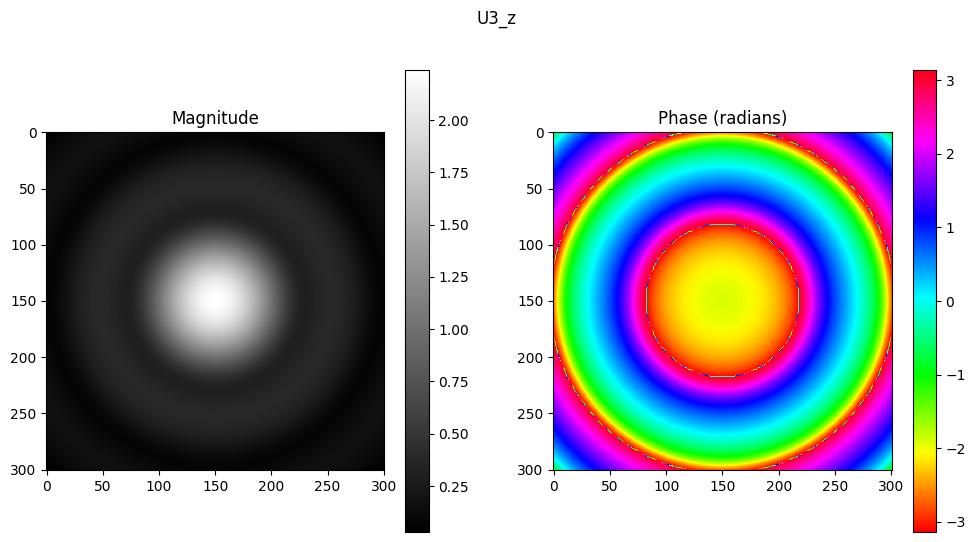

In [329]:
U3_z = propogate_to_z(f+dz)
plot_complex_tensor(U3_z, "U3_z")

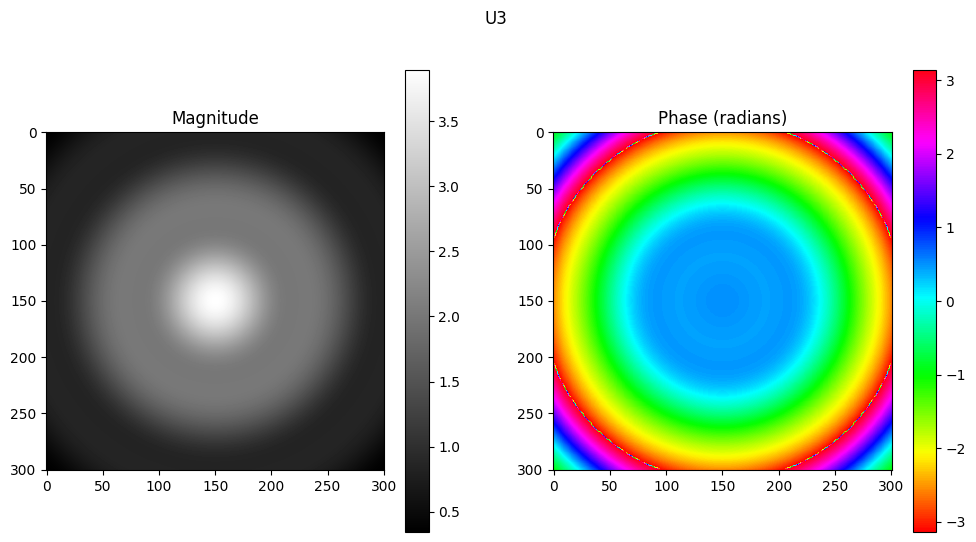

In [330]:
U3_z = propogate_to_z(f-dz)
plot_complex_tensor(U3_z, "U3")

Visualizing the axial plane

In [331]:
delta_z = 4*dx 
Dz = f
z_axial = torch.arange(f+delta_z, f+Dz, delta_z)
nPlanes = z_axial.shape[0]*2 + 1

# U3_3D = torch.zeros(nPlanes, Ny, Nx, dtype=torch.complex64)
axialPlane = torch.zeros(Nx, nPlanes)

U3_f = propogate_to_z(f)
# U3_3D[nPlanes//2] = U3_f
U3_abs_c = torch.abs(U3_f)[Nx//2]
axialPlane[:, nPlanes//2] = U3_abs_c

for i in range(len(z_axial)):
    zi = z_axial[i].item()
    
    U3_zi = propogate_to_z(zi)
    # U3_3D[nPlanes//2 + i] = U3_zi
    # U3_3D[nPlanes//2 - i] = U3_zi

    U3_zi_abs_c = torch.abs(U3_zi)[Nx//2]
    axialPlane[:, nPlanes//2 + i+1] = U3_zi_abs_c
    axialPlane[:, nPlanes//2 - i-1] = U3_zi_abs_c

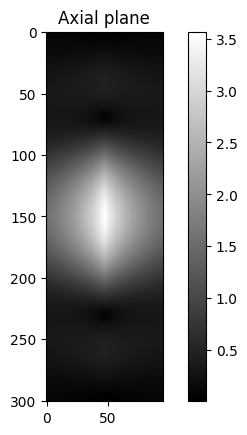

In [332]:
plt.imshow(axialPlane, cmap='grey')
plt.colorbar()
plt.title('Axial plane')
plt.show()

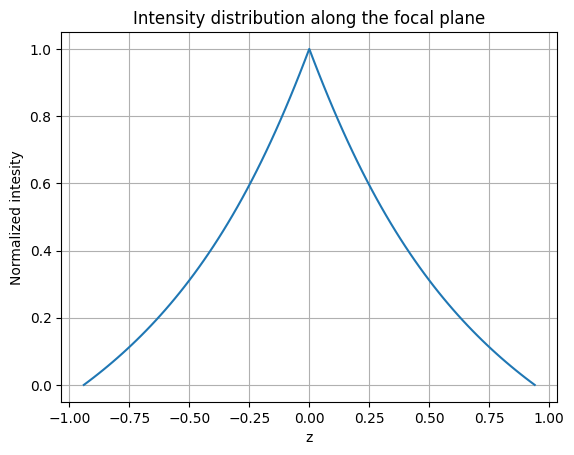

In [333]:
I = axialPlane[Nx//2]
I = (I - I.min()) / (I.max() - I.min() + 1e-10)
xAxis = torch.cat([ -1*torch.flip(z_axial-f, [0]), torch.tensor([0.0]), z_axial-f] ).numpy()

plt.plot(xAxis, I.numpy())
plt.title('Intensity distribution along the focal plane')
plt.xlabel('z')
plt.ylabel('Normalized intesity')
plt.grid(True)
plt.show()

### Coherent image formation (3.3)

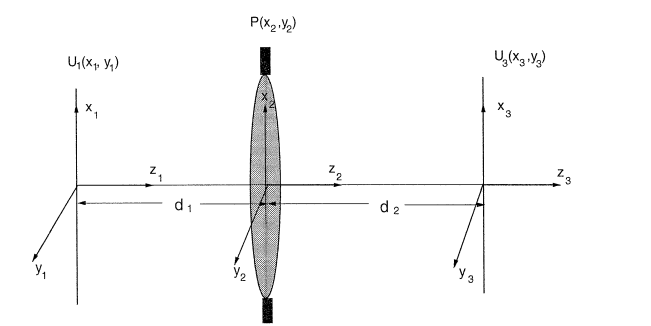